# NLP: Delivery 2, Reproduce Results

## Lily Voge, Jan Urankar, Luka Markicevic, Nikolaos Athanasopoulos, Zoltan Kunos

### Import libraries

In [1]:
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
import pandas as pd
import utils.utils as utils
import pickle
from tqdm import tqdm

import skseq
from skseq.sequences import sequence
from skseq.sequences.sequence import Sequence
from skseq.sequences.sequence_list import SequenceList
from skseq.sequences.label_dictionary import LabelDictionary
import skseq.sequences.structured_perceptron as spc
from skseq.sequences import extended_feature

import skseq
import skseq.sequences.structured_perceptron as spc
from skseq.sequences.sequence_list import SequenceList
from skseq.sequences.label_dictionary import LabelDictionary
import skseq.readers.pos_corpus
import os

In [2]:
df_test = pd.read_csv("data/test_data_ner.csv")
df_tiny = pd.read_csv("data/tiny_test.csv")
df_train = pd.read_csv("data/train_data_ner.csv")

### X_train, Y_train

In [3]:
# Create an array with unique sentence_id values
X_train, Y_train = [], []
unique_id_train = df_train.sentence_id.unique()

for id_tr in tqdm(unique_id_train):
    # Filter the DataFrame based on the desired ID
    X_train.append(df_train[df_train["sentence_id"] == id_tr]["words"].tolist())
    Y_train.append(df_train[df_train["sentence_id"] == id_tr]["tags"].tolist())

100%|████████████████████████████████████| 38366/38366 [00:44<00:00, 866.48it/s]


### X_test, Y_test, test_seq

In [4]:
unique_id_test = df_test.sentence_id.unique()

X_test, Y_test = [], []

for id_te in tqdm(unique_id_test):
    # Filter the DataFrame based on the desired ID
    words = df_test[df_test["sentence_id"] == id_te]["words"].tolist()
    tags = df_test[df_test["sentence_id"] == id_te]["tags"].tolist()

    # Remove items that have "O" tags   # TODO COMMENT THIS AND REMOVE 0-s after viterbi encoding
    #words = [x for x, y in zip(words, tags) if y != "O"]
    #tags = [y for y in tags if y != "O"]

    if len(words) == 0 or len(tags) == 0:
        continue

    # print(words)
    # print(tags)
    # print("\n")
    X_test.append(words)
    Y_test.append(tags)

100%|████████████████████████████████████| 38367/38367 [00:44<00:00, 865.39it/s]


In [5]:
corpus_words_test, corpus_pos_tag_test = utils.create_corpus(X_test, Y_test)
test_seq = SequenceList(LabelDictionary(corpus_words_test), LabelDictionary(corpus_pos_tag_test))

In [6]:
for word, tag in tqdm(zip(X_test, Y_test)): # 38367 iterations
    test_seq.add_sequence(word, tag, LabelDictionary(corpus_words_test), LabelDictionary(corpus_pos_tag_test))

38367it [04:43, 135.32it/s]


In [7]:
# Check if the file exists
if os.path.exists("./fitted_models/test_seq.pkl"):
    # Delete the file
    os.remove("./fitted_models/test_seq.pkl")

In [8]:
with open("./fitted_models/test_seq.pkl", 'wb') as file:
    pickle.dump(test_seq, file)

### Load models

In [9]:
train_seq = pickle.load(open("./fitted_models/train_seq.dill", "rb"))
test_seq = pickle.load(open("./fitted_models/test_seq.pkl", "rb"))

In [10]:
train_seq[1000].to_words(sequence_list = train_seq)

'Naqib/B-per and/O some/O of/O his/O family/O members/O and/O guards/O were/O wounded/O in/O the/O blast/O and/O at/O least/O two/O others/O were/O killed/O ./O '

In [11]:
feature_mapper = skseq.sequences.id_feature.IDFeatures(train_seq)
feature_mapper.build_features()

In [12]:
corpus_words, corpus_pos_tag = utils.create_corpus(X_train, Y_train)
sp = spc.StructuredPerceptron(corpus_words, corpus_pos_tag, feature_mapper)

In [13]:
corpus_pos_tag

{'O': 0,
 'B-geo': 1,
 'B-gpe': 2,
 'B-tim': 3,
 'B-org': 4,
 'I-geo': 5,
 'B-per': 6,
 'I-per': 7,
 'I-org': 8,
 'B-art': 9,
 'I-art': 10,
 'I-tim': 11,
 'I-gpe': 12,
 'B-nat': 13,
 'I-nat': 14,
 'B-eve': 15,
 'I-eve': 16}

In [14]:
sp.load_model("./fitted_models/01_Default_Features")

In [15]:
print(feature_mapper.dataset.y_dict)

{'O': 0, 'B-geo': 1, 'B-gpe': 2, 'B-tim': 3, 'B-org': 4, 'I-geo': 5, 'B-per': 6, 'I-per': 7, 'I-org': 8, 'B-art': 9, 'I-art': 10, 'I-tim': 11, 'I-gpe': 12, 'B-nat': 13, 'I-nat': 14, 'B-eve': 15, 'I-eve': 16}


## Default Features Model

### Test Evaluation

In [16]:
test_tag_pos = [[corpus_pos_tag[i] for i in list_y] for list_y in Y_test]
y_true = [tag for array in test_tag_pos for tag in array]

01. Metrics:


,Correct Sentences,Correct Tags,Weighted F1 Score,Accuracy
0,25.78,25.05,85.79,25.05



02. Confusion matrix:


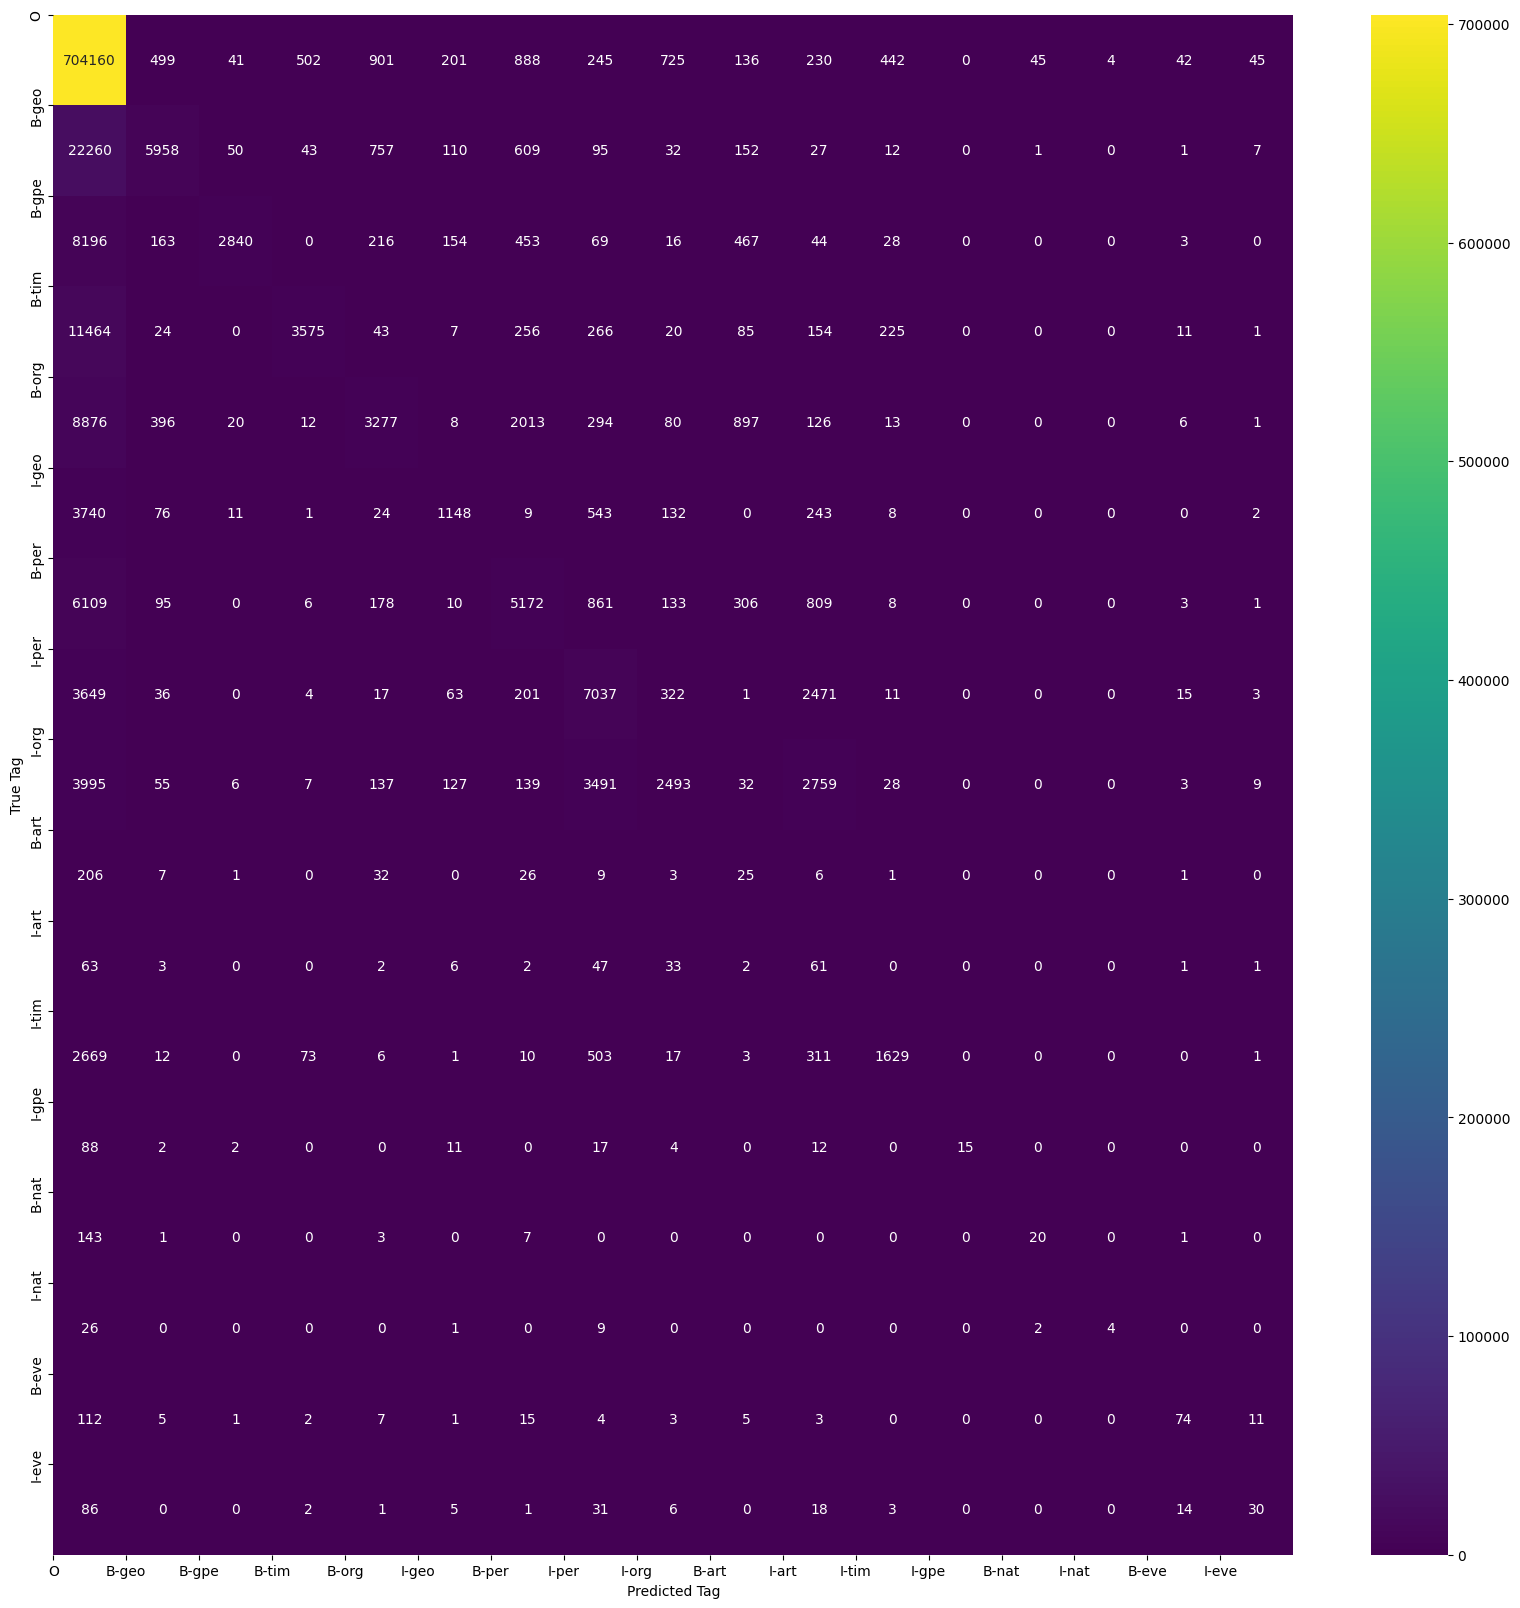


03. Metrics by tag:


,precision,recall,f1-score
O,0.907607,0.993025,0.948397
B-geo,0.812602,0.197848,0.318218
B-gpe,0.955585,0.224524,0.363613
B-tim,0.845753,0.221623,0.351213
B-org,0.585074,0.204570,0.303145
I-geo,0.619536,0.193364,0.294737
B-per,0.527701,0.377766,0.440320
I-per,0.520450,0.508821,0.514570
I-org,0.620304,0.187712,0.288208
B-art,0.011843,0.078864,0.020593


In [17]:
_ = utils.evaluate(sp, X_test, test_tag_pos, corpus_pos_tag, y_true, save_name="default_features", dataframe = None)

### Train Evaluation

In [18]:
train_tag_pos = [[corpus_pos_tag[i] for i in list_y] for list_y in Y_train]
y_true_train = [tag for array in train_tag_pos for tag in array]

01. Metrics:


,Correct Sentences,Correct Tags,Weighted F1 Score,Accuracy
0,63.92,80.13,96.82,80.13



02. Confusion matrix:


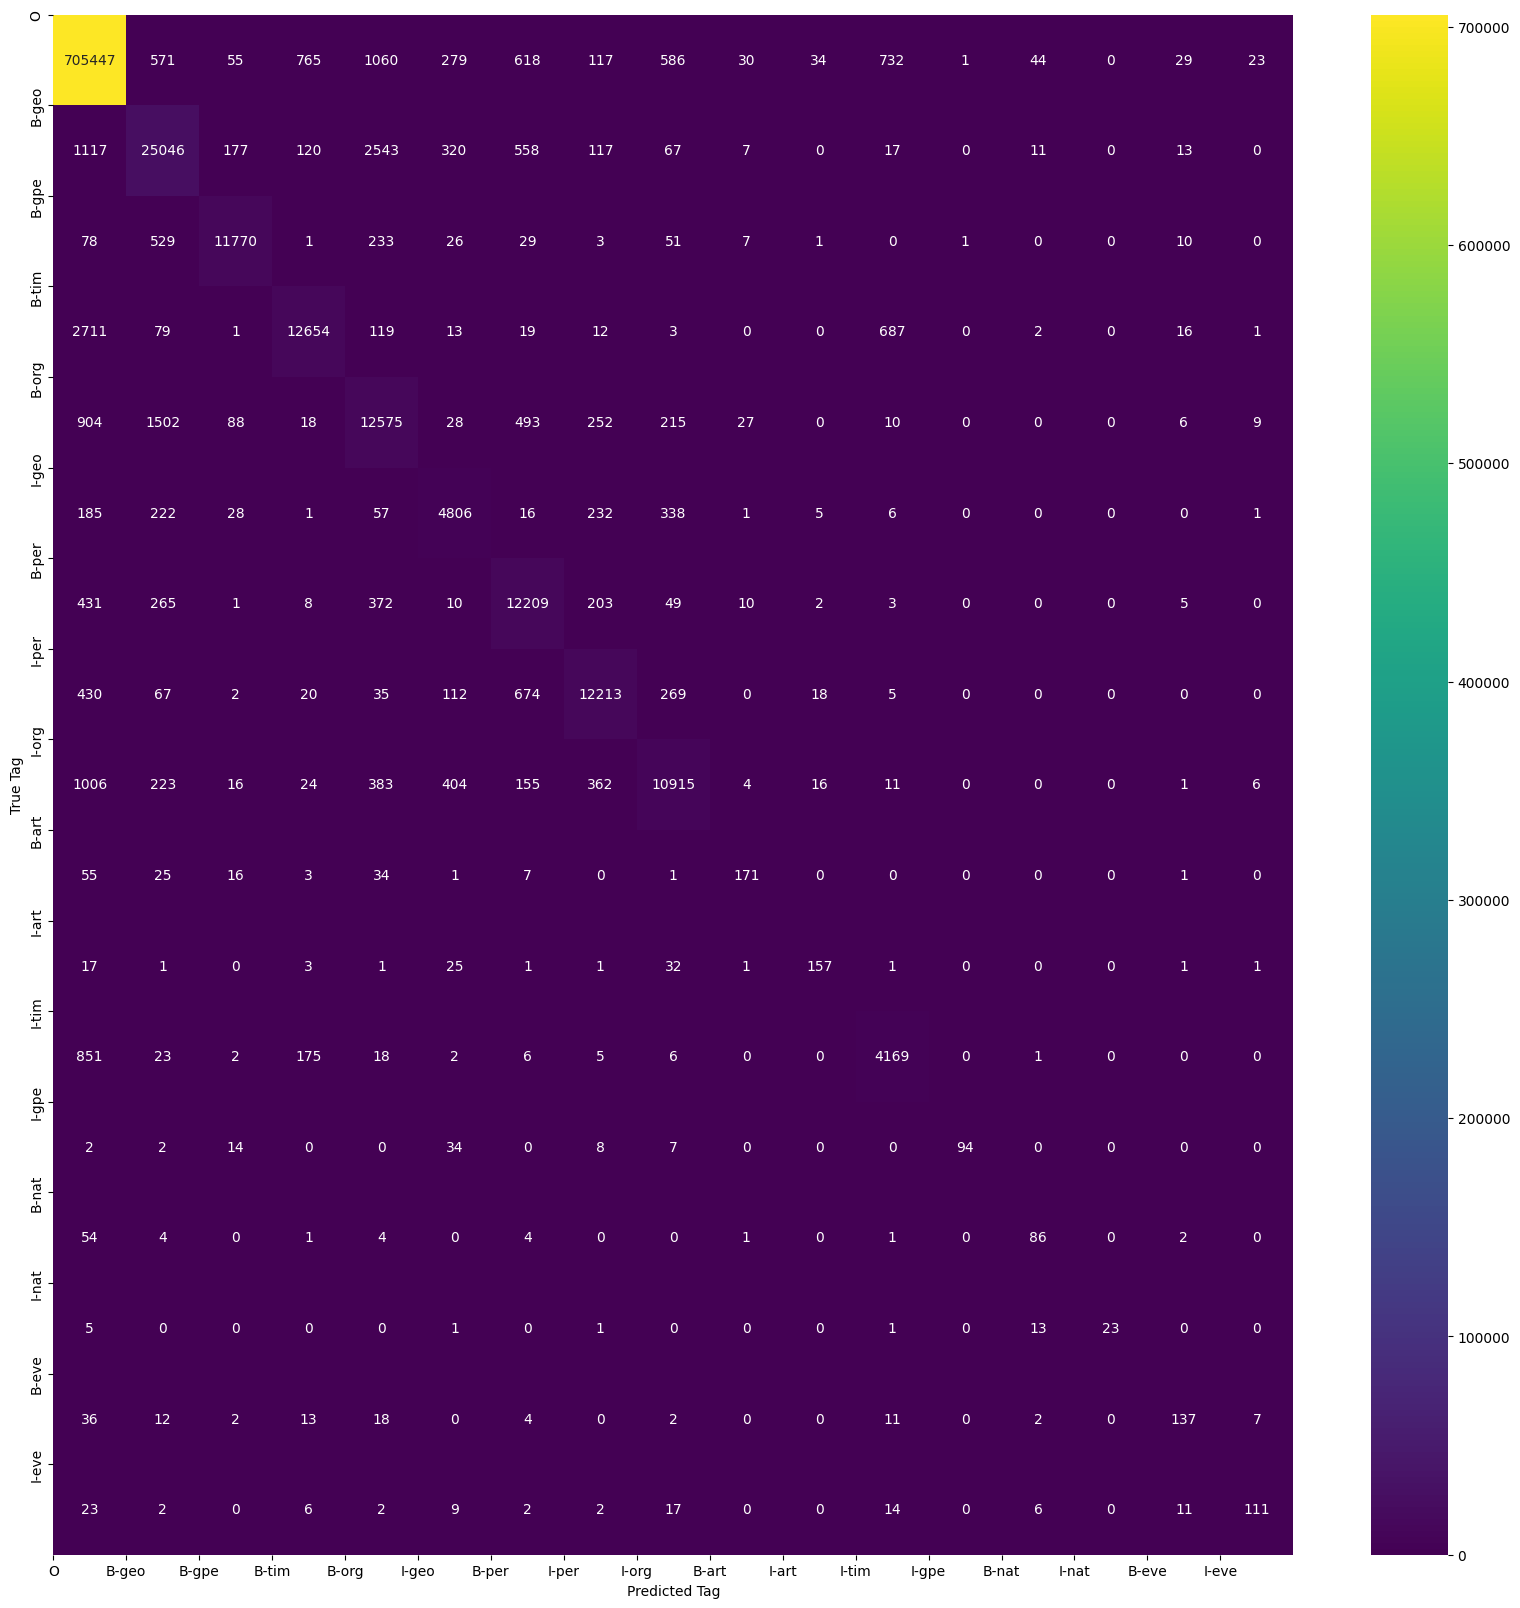


03. Metrics by tag:


,precision,recall,f1-score
O,0.988919,0.993040,0.990975
B-geo,0.876562,0.831734,0.853560
B-gpe,0.966973,0.923934,0.944964
B-tim,0.916160,0.775510,0.839988
B-org,0.720465,0.779748,0.748935
I-geo,0.791763,0.814852,0.803142
B-per,0.825211,0.899838,0.860910
I-per,0.902794,0.882124,0.892339
I-org,0.869167,0.806964,0.836912
B-art,0.660232,0.544586,0.596859


In [19]:
_ = utils.evaluate(sp, X_train, train_tag_pos, corpus_pos_tag, y_true_train, save_name="default_features_train", dataframe = None)

### TINY_TEST Evaluation

In [20]:
unique_id_tiny = df_tiny.sentence_id.unique()

X_tiny, Y_tiny = [], []

for id_te in unique_id_tiny:
    # Filter the DataFrame based on the desired ID
    words = df_tiny[df_tiny["sentence_id"] == id_te]["words"].tolist()
    tags = df_tiny[df_tiny["sentence_id"] == id_te]["tags"].tolist()

    X_tiny.append(words)
    Y_tiny.append(tags)

In [21]:
tiny_tag_pos = [[corpus_pos_tag[i] for i in list_y] for list_y in Y_tiny]
y_true_tiny = [tag for array in tiny_tag_pos for tag in array]

01. Metrics:


,Correct Sentences,Correct Tags,Weighted F1 Score,Accuracy
0,30.77,61.76,91.17,61.76



02. Confusion matrix:


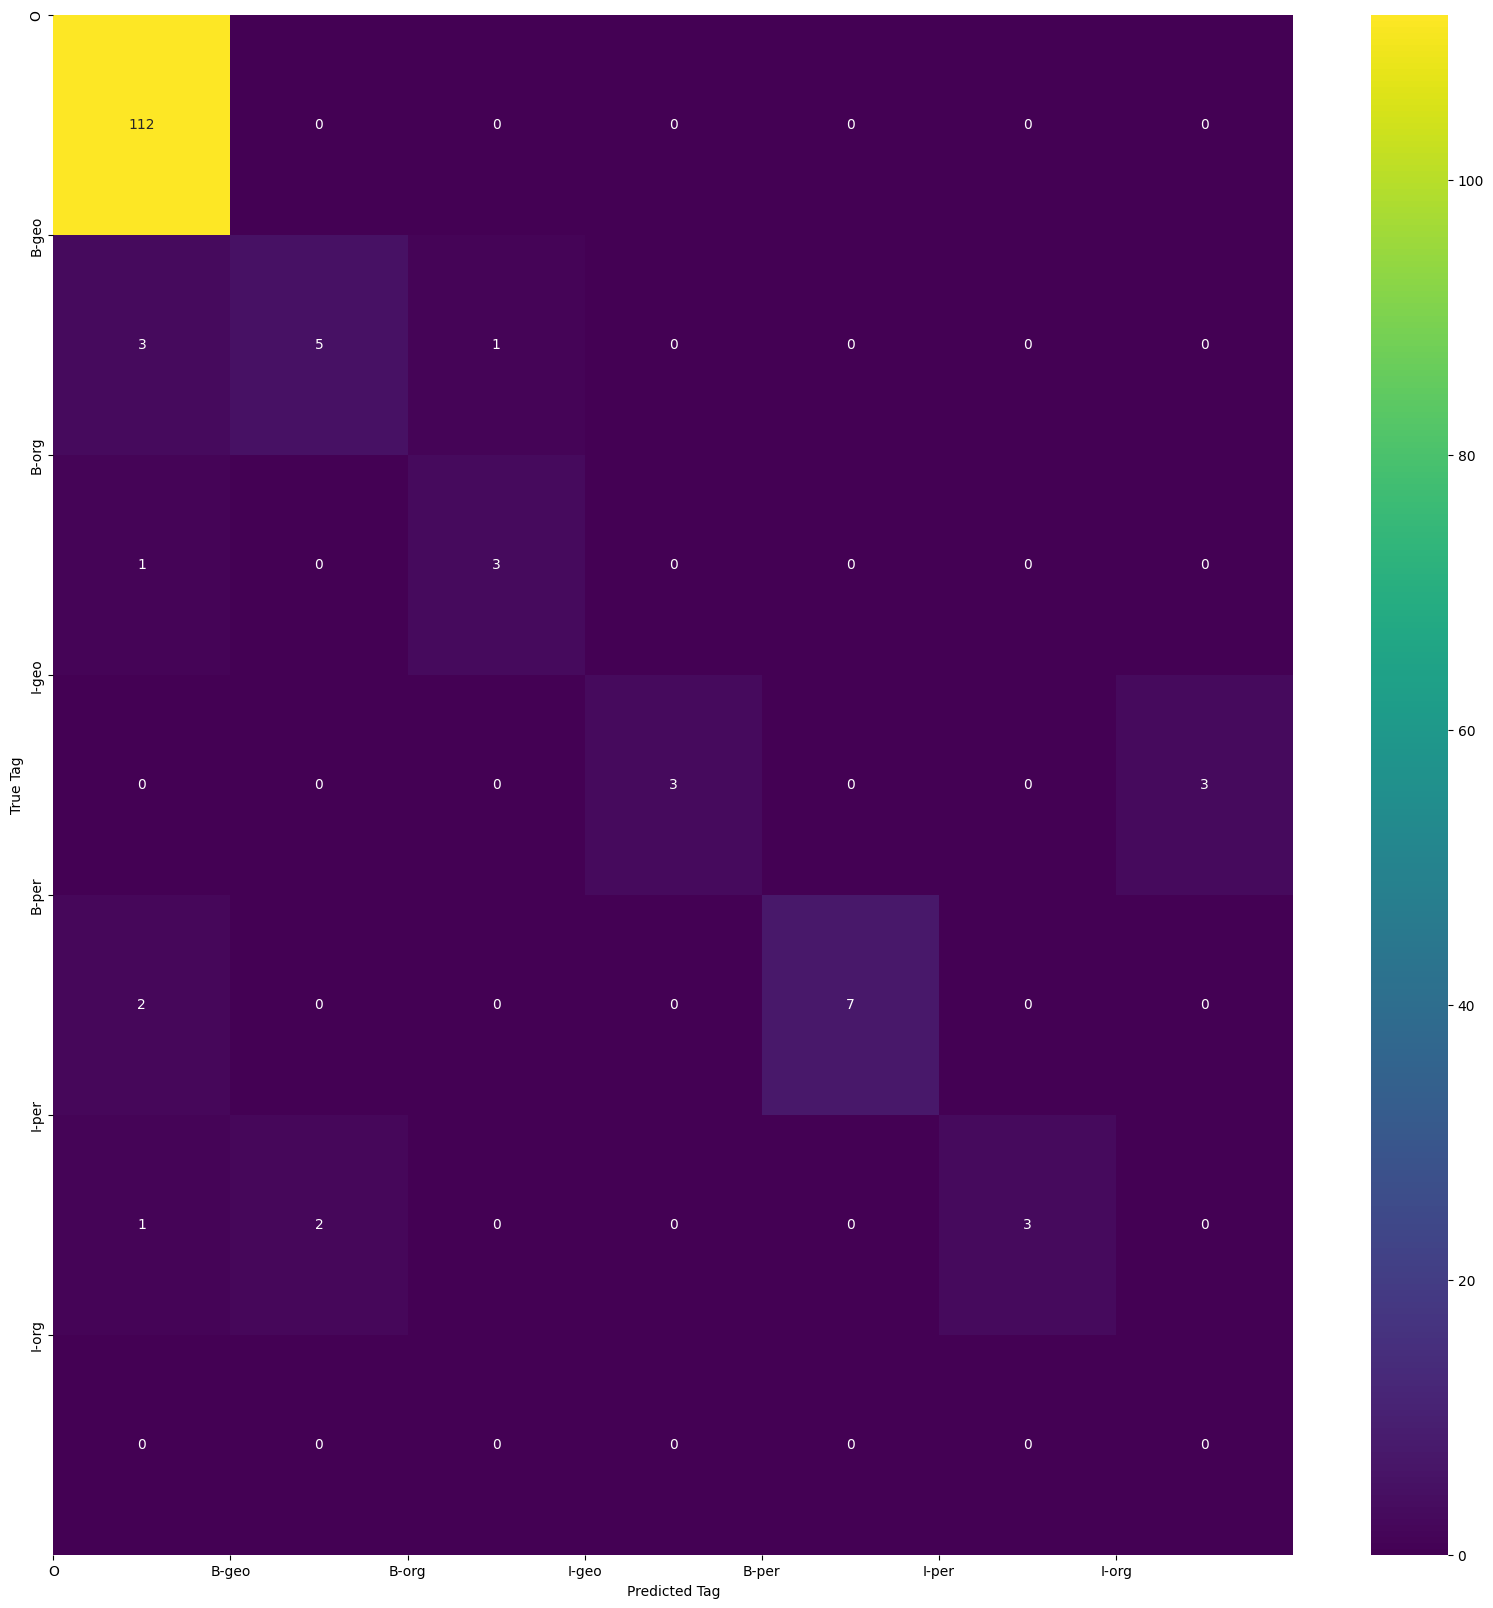


03. Metrics by tag:


/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score
O,0.941176,1.000000,0.969697
B-geo,0.714286,0.555556,0.625000
B-org,0.750000,0.750000,0.750000
I-geo,1.000000,0.500000,0.666667
B-per,1.000000,0.777778,0.875000
I-per,1.000000,0.500000,0.666667
I-org,0.000000,0.000000,0.000000
accuracy,0.910959,0.910959,0.910959
macro avg,0.772209,0.583333,0.650433
weighted avg,0.930413,0.910959,0.911685


In [22]:
_ = utils.evaluate(sp, X_tiny, tiny_tag_pos, corpus_pos_tag, y_true_tiny, save_name="default_features_tiny", dataframe = None)

In [23]:
for sentence in X_tiny:
    print(sp.viterbi_decode(Sequence(x=sentence, y=[int(0) for w in sentence]))[0].to_words(train_seq, only_tag_translation=True),"\n")

The/O programmers/O from/O Barcelona/B-geo might/O write/O a/O sentence/O without/O a/O spell/O checker/O ./O  

The/O programmers/O from/O Barchelona/O cannot/O write/O a/O sentence/O without/O a/O spell/O checker/O ./O  

Jack/B-per London/B-geo went/O to/O Parris/O ./O  

Jack/B-per London/B-geo went/O to/O Paris/B-geo ./O  

Bill/B-per gates/I-per and/O Steve/B-per jobs/O never/O thought/O Microsoft/B-org would/O become/O such/O a/O big/O company/O ./O  

Bill/B-per Gates/I-per and/O Steve/B-per Jobs/I-per never/O thought/O Microsoft/B-org would/O become/O such/O a/O big/O company/O ./O  

The/O president/O of/O U.S.A/O thought/O they/O could/O win/O the/O war/O ./O  

The/O president/O of/O the/O United/B-org States/I-org of/I-org America/I-org thought/O they/O could/O win/O the/O war/O ./O  

The/O king/O of/O Saudi/B-geo Arabia/I-geo wanted/O total/O control/O ./O  

Robin/O does/O not/O want/O to/O go/O to/O Saudi/B-geo Arabia/I-geo ./O  

Apple/O is/O a/O great/O company/O ./O

## Added Features Perceptron Model

In [24]:
added_feature_mapper = skseq.sequences.extended_feature.ExtendedFeatures(train_seq) 
# get features
added_feature_mapper.build_features()

added = ["capi","point","ending","prep"]
for index,feat_type in enumerate(added):
    print(str(index)+". "+feat_type,end="\n")
    print([feature for feature in list(added_feature_mapper.feature_dict.keys()) if feat_type in feature],end="\n\n")

0. capi
['capi_ini::O', 'capi_ini::B-geo', 'capi_ini::B-gpe', 'capi_ini::B-tim', 'capi_ini::B-org', 'capi_ini::I-geo', 'capi_any::B-geo', 'capi_ini::B-per', 'capi_ini::I-per', 'capi_any::O', 'capi_ini::I-org', 'capi_ini::B-art', 'capi_any::B-art', 'capi_ini::I-art', 'id:capital::O', 'capi_any::B-org', 'capi_any::I-tim', 'capi_any::I-org', 'capi_any::B-tim', 'capi_ini::I-tim', 'id:capita::O', 'capi_any::B-per', 'capi_ini::I-gpe', 'capi_any::B-gpe', 'capi_any::I-per', 'capi_ini::B-nat', 'capi_ini::I-nat', 'capi_ini::B-eve', 'capi_ini::I-eve', 'capi_any::B-nat', 'capi_any::I-art', 'capi_any::I-geo', 'capi_any::B-eve', 'id:capitals::O', 'id:capitalize::O', 'id:decapitated::O', 'capi_any::I-eve', 'id:capitalist::O', 'id:capital-intensive::O', 'id:landscaping::O', 'id:per-capita::O', 'id:capitalization::O', 'id:capitalized::O', 'id:escaping::O', 'capi_any::I-gpe', 'id:capitalism::O', 'capi_any::I-nat', 'id:anti-capitalist::O', 'id:capitol::O']

1. point
['inside_point::O', 'inside_point::B-g

In [25]:
sp_added = spc.StructuredPerceptron(corpus_words, corpus_pos_tag, added_feature_mapper)

In [26]:
sp_added.load_model(dir="fitted_models/02_Added_Features")

### Test Evaluation

01. Metrics:


,Correct Sentences,Correct Tags,Weighted F1 Score,Accuracy
0,25.93,35.13,89.28,35.13



02. Confusion matrix:


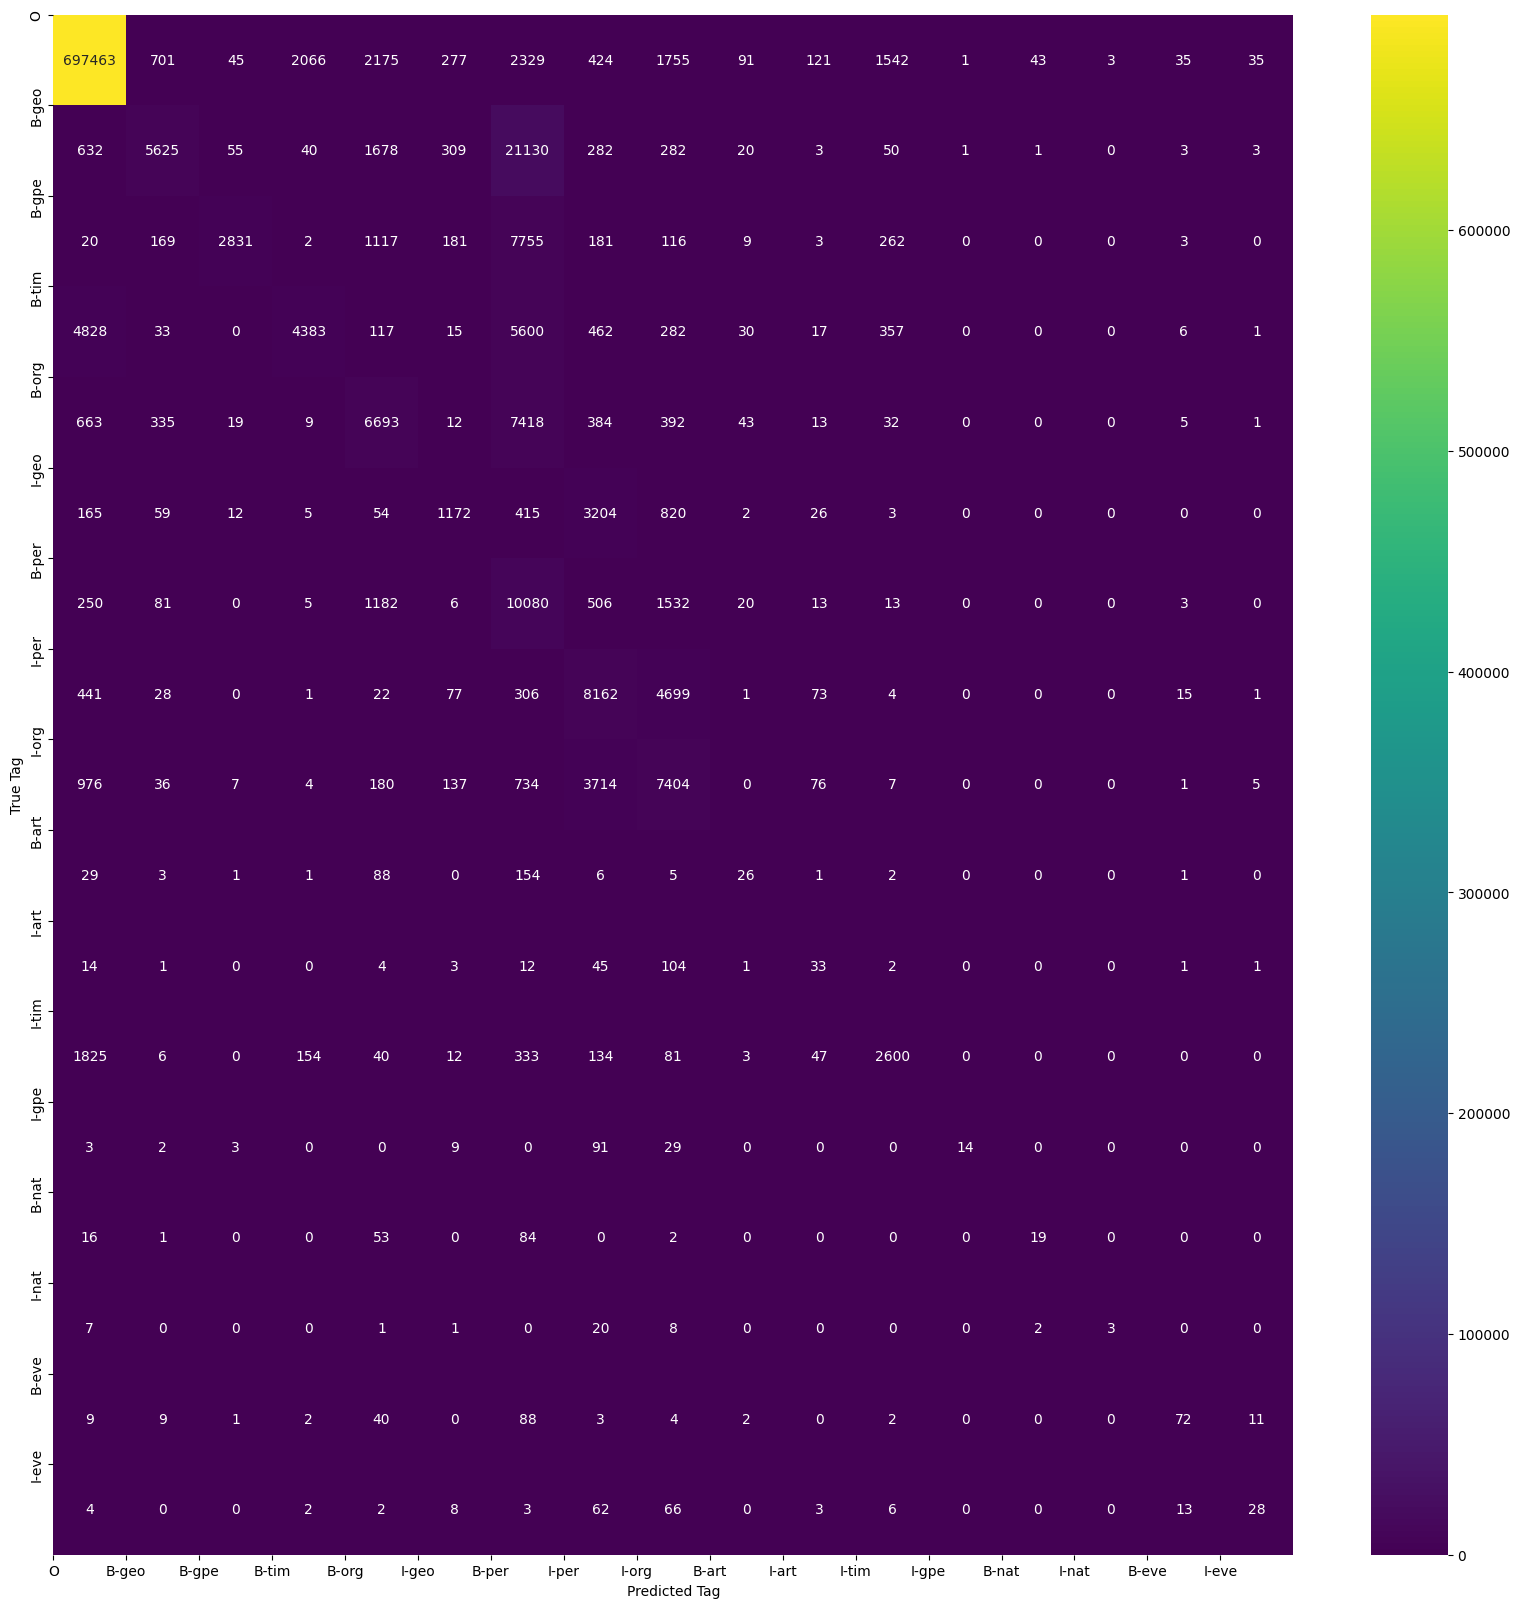


03. Metrics by tag:


,precision,recall,f1-score
O,0.986029,0.983581,0.984804
B-geo,0.793483,0.186790,0.302395
B-gpe,0.951917,0.223812,0.362414
B-tim,0.656728,0.271713,0.384389
B-org,0.497769,0.417816,0.454302
I-geo,0.528166,0.197406,0.287396
B-per,0.178594,0.736250,0.287458
I-per,0.461652,0.590166,0.518058
I-org,0.421136,0.557488,0.479813
B-art,0.104839,0.082019,0.092035


In [27]:
_ = utils.evaluate(sp_added, X_test, test_tag_pos, corpus_pos_tag, y_true, save_name="added_features", dataframe = None)

### Train Evaluation

01. Metrics:


,Correct Sentences,Correct Tags,Weighted F1 Score,Accuracy
0,57.68,77.42,96.36,77.42



02. Confusion matrix:


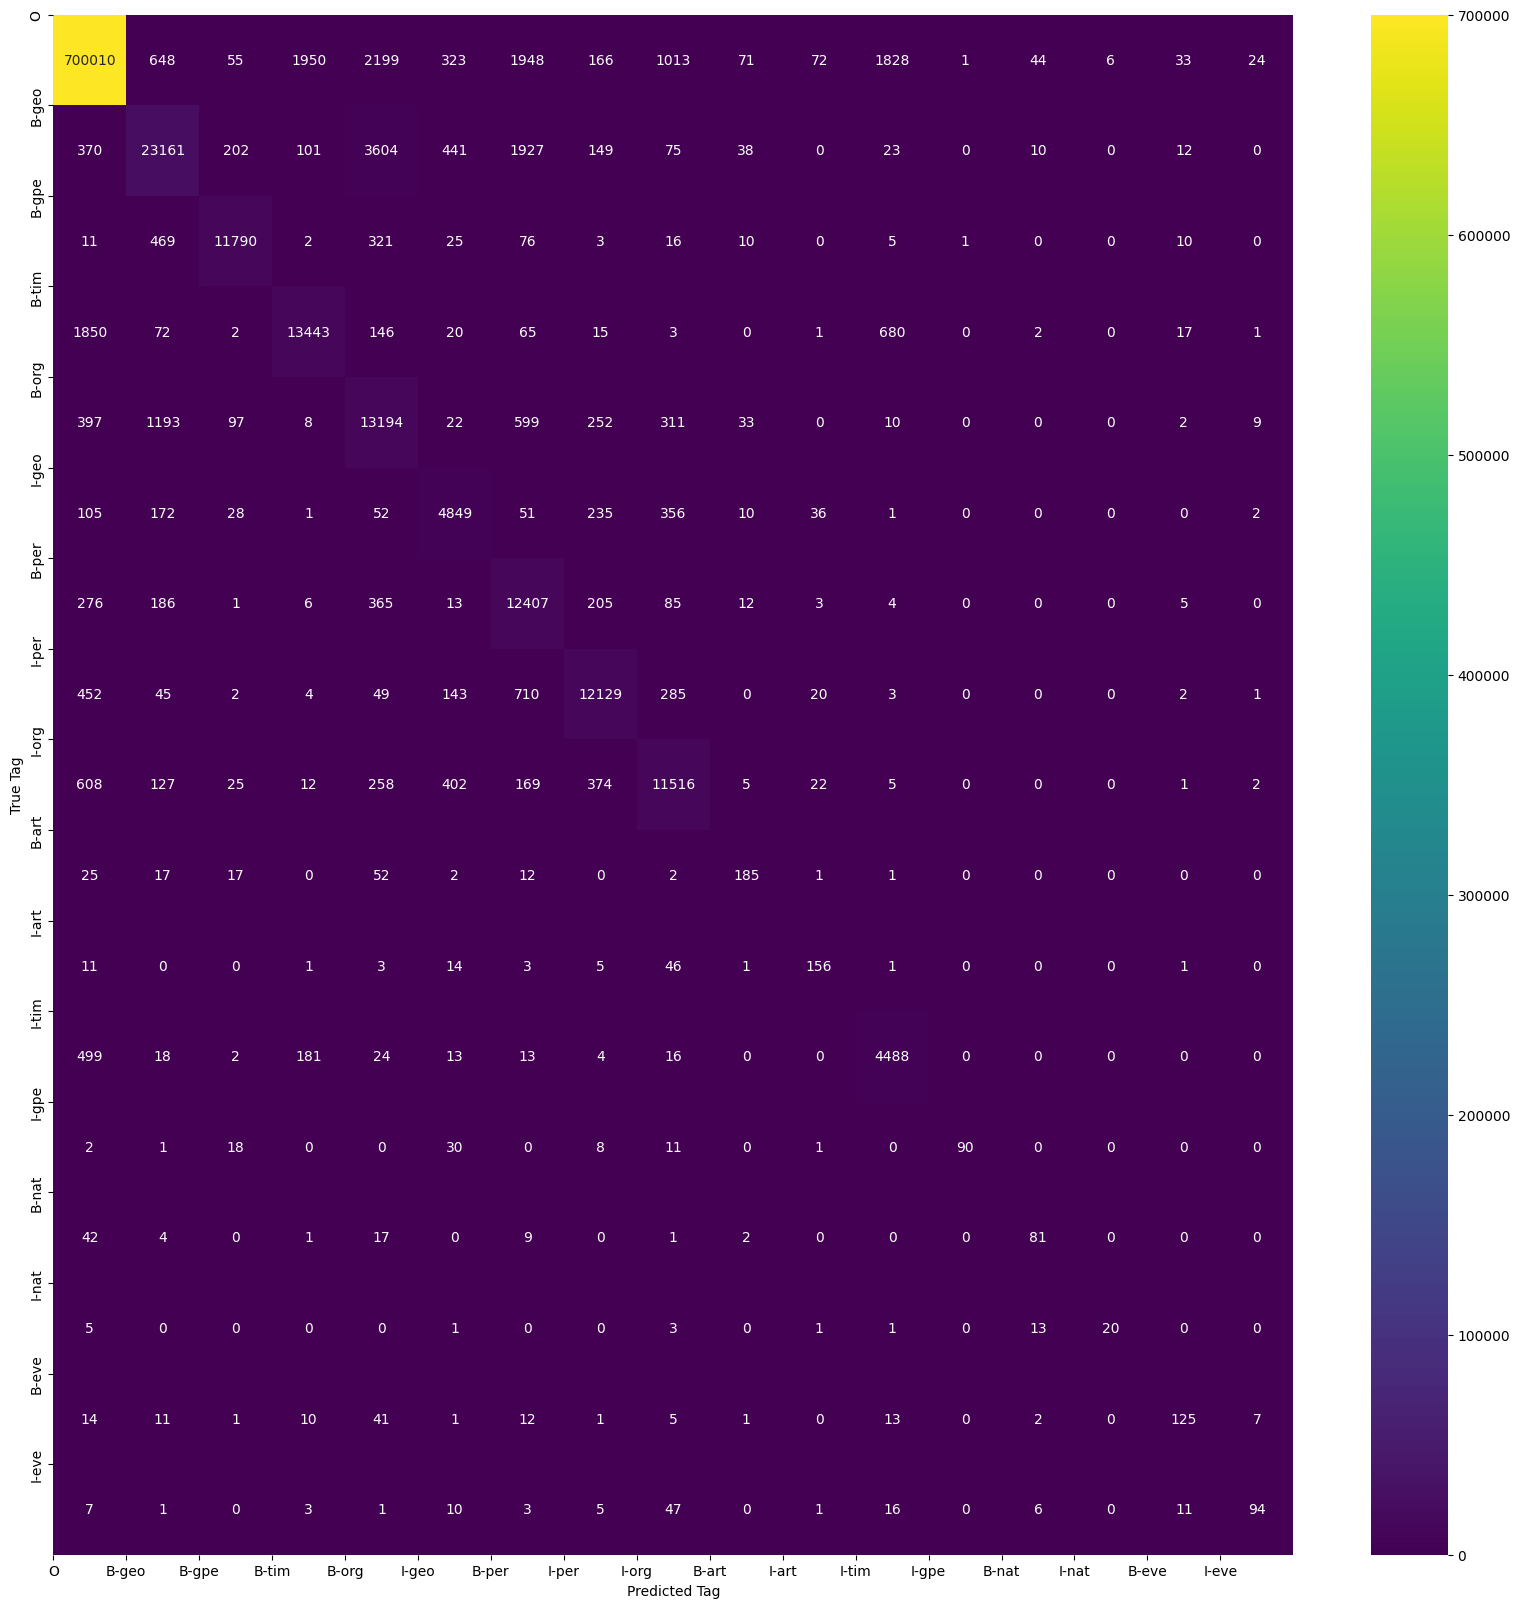


03. Metrics by tag:


,precision,recall,f1-score
O,0.993367,0.985387,0.989361
B-geo,0.886545,0.769136,0.823678
B-gpe,0.963235,0.925504,0.943993
B-tim,0.854990,0.823865,0.839139
B-org,0.649119,0.818131,0.723891
I-geo,0.768585,0.822143,0.794462
B-per,0.689125,0.914431,0.785950
I-per,0.895063,0.876056,0.885458
I-org,0.835037,0.851397,0.843138
B-art,0.502717,0.589172,0.542522


In [28]:
_ = utils.evaluate(sp_added, X_train, train_tag_pos, corpus_pos_tag, y_true_train, save_name="added_features_train", dataframe = None)

### TINY_Test Evaluation

01. Metrics:


,Correct Sentences,Correct Tags,Weighted F1 Score,Accuracy
0,38.46,64.71,90.87,64.71



02. Confusion matrix:


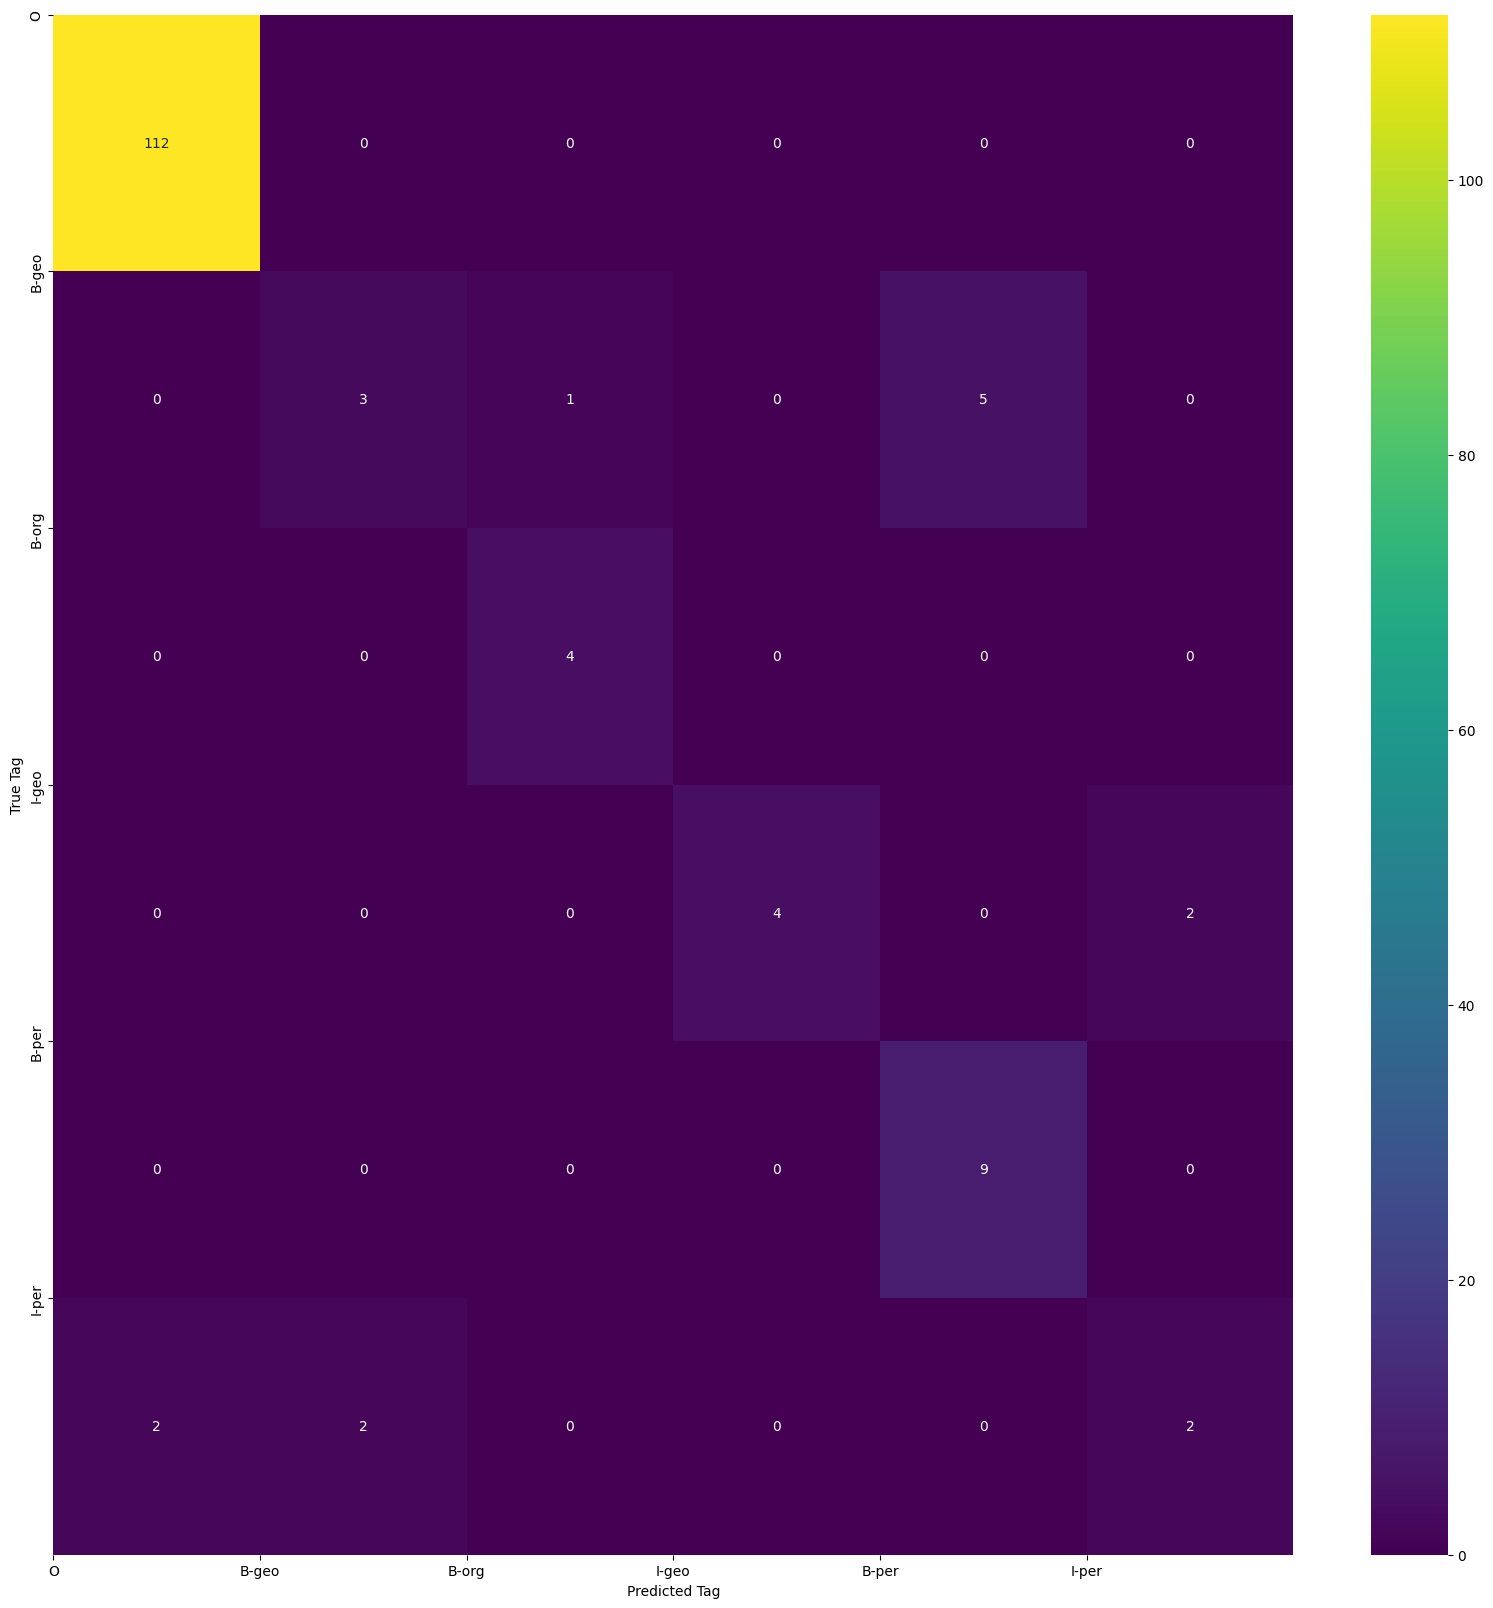


03. Metrics by tag:


,precision,recall,f1-score
O,0.982456,1.000000,0.991150
B-geo,0.600000,0.333333,0.428571
B-org,0.800000,1.000000,0.888889
I-geo,1.000000,0.666667,0.800000
B-per,0.642857,1.000000,0.782609
I-per,0.500000,0.333333,0.400000
accuracy,0.917808,0.917808,0.917808
macro avg,0.754219,0.722222,0.715203
weighted avg,0.913841,0.917808,0.908665


In [29]:
_ = utils.evaluate(sp_added, X_tiny, tiny_tag_pos, corpus_pos_tag, y_true_tiny, save_name="added_features_tiny",dataframe = None)

In [30]:
for sentence in X_tiny:
    print(sp_added.viterbi_decode(
        Sequence(x=sentence, y=[int(0) for w in sentence]))[0].to_words(train_seq, only_tag_translation=True),"\n")

The/O programmers/O from/O Barcelona/B-org might/O write/O a/O sentence/O without/O a/O spell/O checker/O ./O  

The/O programmers/O from/O Barchelona/B-per cannot/O write/O a/O sentence/O without/O a/O spell/O checker/O ./O  

Jack/B-per London/B-geo went/O to/O Parris/B-per ./O  

Jack/B-per London/B-geo went/O to/O Paris/B-geo ./O  

Bill/B-per gates/O and/O Steve/B-per jobs/O never/O thought/O Microsoft/B-org would/O become/O such/O a/O big/O company/O ./O  

Bill/B-per Gates/I-per and/O Steve/B-per Jobs/I-per never/O thought/O Microsoft/B-org would/O become/O such/O a/O big/O company/O ./O  

The/O president/O of/O U.S.A/B-per thought/O they/O could/O win/O the/O war/O ./O  

The/O president/O of/O the/O United/B-geo States/I-geo of/I-geo America/I-geo thought/O they/O could/O win/O the/O war/O ./O  

The/O king/O of/O Saudi/B-per Arabia/I-per wanted/O total/O control/O ./O  

Robin/B-per does/O not/O want/O to/O go/O to/O Saudi/B-per Arabia/I-per ./O  

Apple/B-org is/O a/O great